### Adapt inverse kinematics to ground locomotion data

This notebook contains the process to compute the inverse kinematics from the 3D pose measured in the flytracker setup. 

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import pandas as pd
import glob
import pickle
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

import matplotlib
matplotlib.pyplot.set_loglevel (level = 'warning')

from nmf_ik.utils import dict_to_nparray_pose, save_file, interpolate_signal, calculate_nmf_size
from nmf_ik.data import BOUNDS, NMF_SIZE, NMF_TEMPLATE, INITIAL_ANGLES
from nmf_ik.leg_inverse_kinematics import LegInverseKinematics
from nmf_ik.kinematic_chain import KinematicChainYPR
from nmf_ik.visualization import plot_3d_points, animate_3d_points

import sys

DATA_PATH = Path("data")

aligned_pose_path = DATA_PATH / "df3dpp_output/aligned_df3dpp.pkl"
# Next two data come from the paper
aligned_pose_pp = pd.read_pickle(aligned_pose_path)
output_path = DATA_PATH / "seqikpy_output"


ANGLES = [
    "ThC_yaw",
    "ThC_pitch",
    "ThC_roll",
    "CTr_pitch",
    "CTr_roll",
    "FTi_pitch",
    "TiTa_pitch",
]

## Dictionary conversion

In [2]:
# Aligned pose now in a nested dictionary format. -> dictionary[leg_name][key_point_name][raw_pos_aligned]
# My package is using numpy arrays, so we convert the pose dictionary into a compatible format

print(aligned_pose_pp.keys())
converted_aligned_pose = {}

for leg_name, leg_pose_data in aligned_pose_pp.items():
    if leg_name in ["meta", "swing_stance_time"]:
        continue
#     print(leg_pose_data.keys())
    converted_aligned_pose[leg_name] = dict_to_nparray_pose(
        leg_pose_data, claw_is_end_effector=True
    )

dict_keys(['RF_leg', 'RM_leg', 'RH_leg', 'LF_leg', 'LM_leg', 'LH_leg', 'swing_stance_time', 'meta'])


In [3]:
print(converted_aligned_pose.keys())

converted_aligned_pose['RF_leg'].shape # timestep, key points, coordinates (x,y,z)

dict_keys(['RF_leg', 'RM_leg', 'RH_leg', 'LF_leg', 'LM_leg', 'LH_leg'])


(94, 5, 3)

In [4]:
# let's save the new dictionary
export_path_seqikpy_format_aligned_pos = output_path / 'pose3d_aligned.pkl'
export_path_seqikpy_format_aligned_pos.parent.mkdir(parents=True, exist_ok=True)
save_file(export_path_seqikpy_format_aligned_pos, converted_aligned_pose)

In [5]:
# We will use these configs for the 3D plotting
KEY_POINTS_DICT = {
    "LH": (np.arange(25, 30), "solid"),
    "LM": (np.arange(20, 25), "solid"),
    "LF": (np.arange(15, 20), "solid"),
    "RH": (np.arange(10, 15), "solid"),
    "RM": (np.arange(5, 10), "solid"),
    "RF": (np.arange(0, 5), "solid"),
}

KEY_POINTS_DICT2 = {
    "LH": (np.arange(45, 54), ":"),
    "LM": (np.arange(36, 45), ":"),
    "LF": (np.arange(27, 36), ":"),
    "RH": (np.arange(18, 27), ":"),
    "RM": (np.arange(9, 18), ":"),
    "RF": (np.arange(0, 9), ":"),
}

In [6]:
def set_box_aspect(ax, aspect):
    """Set aspect ratio of a 3D plot."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    
    xmean = np.mean(xlim)
    ymean = np.mean(ylim)
    zmean = np.mean(zlim)
    
    plot_radius = max([abs(lim - mean_)
                       for lims, mean_ in ((xlim, xmean),
                                           (ylim, ymean),
                                           (zlim, zmean))
                       for lim in lims])
    
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])

In [7]:
points_aligned_all = np.concatenate(
    (
        converted_aligned_pose["RF_leg"],
        converted_aligned_pose["RM_leg"],
        converted_aligned_pose["RH_leg"],
        converted_aligned_pose["LF_leg"],
        converted_aligned_pose["LM_leg"],
        converted_aligned_pose["LH_leg"],
    ),
    axis=1,
)

ax_limits = [-2.0, 2.0]

aligned_pose_export_path = DATA_PATH / 'seqikpy_output/aligned_pose'
aligned_pose_export_path.mkdir(parents=True, exist_ok=True)
for t in range(0, points_aligned_all.shape[0], 1):
    for k, (azim, elev) in enumerate([(90,0),(90,90), (30, 10)]):

        fig = plt.figure(figsize=(12, 12), layout="compressed")
        ax3d = fig.add_subplot(111, projection="3d")
        ax3d.view_init(azim=azim, elev=elev)

        ax3d.set_xlabel('x')
        ax3d.set_ylabel('y')
        ax3d.set_zlabel('z')
        
        plot_3d_points(
            ax3d,
            points_aligned_all,
            KEY_POINTS_DICT,
            label_prefix="",
            t=t,
            fix_lim=True,
            export_path=None,
            lw = 4.0,
        )

        ax3d.set_xlim([-2.0, 2.0])
        ax3d.set_ylim([-2.0, 2.0])
        ax3d.set_zlim([-2.0, 2.0])

        #ax3d.axis('off')
        ax3d.set_facecolor('black')  # Set black background
        
        # remove legend 
        if k != 1:
            ax3d.get_legend().remove()
        else:
            legend = ax3d.legend(fontsize=15, frameon=False, ncols=2, loc="lower center")
            frame = legend.get_frame()
            # Adjust legend position
            ax3d.add_artist(legend)
            legend.set_bbox_to_anchor((0.32, 0.28))

        # set aspect ratio
        set_box_aspect(ax3d, aspect = 1)

        # tight layout
        plt.tight_layout()
        # save without edges
        plt.savefig(aligned_pose_export_path/ f'azim_{azim}_elev_{elev}_{t}.png', bbox_inches="tight", dpi=100, pad_inches=-1.5)

        plt.close()

## Using sequential Inverse Kinematics

In [8]:
# Now we converted the aligned pose from nested dictionary to numpy arrays.
# Let's start using seq_ik

# Step 1: alignment - already done using DF3DPP so we can skip

# Step 2. calculation of joint angles
# We are defining a set of initial seeds for the IK optimization

INITIAL_ANGLES_LOCOMOTION = {
    "RF": {
        # Base ThC yaw pitch CTr pitch
        "stage_1": np.array([0.0, 0.45, -0.07, -2.14]),
        # Base ThC yaw pitch roll CTr pitch CTr roll
        "stage_2": np.array([0.0, 0.45, -0.07, -0.32, -2.14, 1.4]),
        # Base ThC yaw pitch roll CTr pitch CTr roll FTi pitch
        "stage_3": np.array([0.0, 0.45, -0.07, -0.32, -2.14, -1.25, 1.48, 0.0]),
        # Base ThC yaw pitch roll CTr pitch CTr roll FTi pitch TiTa pitch
        "stage_4": np.array([0.0, 0.45, -0.07, -0.32, -2.14, -1.25, 1.48, 0.0, 0.0]),
    },

    "LF": {
        "stage_1": np.array([0.0, -0.45, -0.07, -2.14]),
        "stage_2": np.array([0.0, -0.45, -0.07, 0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, -0.45, -0.07, 0.32, -2.14, 1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, -0.45, -0.07, 0.32, -2.14, 1.25, 1.48, 0.0, 0.0]),
    },

    "RM": {
        "stage_1": np.array([0.0, 0.45, 0.37, -2.14]),
        "stage_2": np.array([0.0, 0.45, 0.37, -0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, 0.45, 0.37, -0.32, -2.14, -1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, 0.45, 0.37, -0.32, -2.14, -1.25, 1.48, 0.0, 0.0]),
    },

    "LM": {
        "stage_1": np.array([0.0, -0.45, 0.37, -2.14]),
        "stage_2": np.array([0.0, -0.45, 0.37, 0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, -0.45, 0.37, 0.32, -2.14, 1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, -0.45, 0.37, 0.32, -2.14, 1.25, 1.48, 0.0, 0.0]),
    },

    "RH": {
        "stage_1": np.array([0.0, 0.45, 0.07, -2.14]),
        "stage_2": np.array([0.0, 0.45, 0.07, -0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, 0.45, 0.07, -0.32, -2.14, -1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, 0.45, 0.07, -0.32, -2.14, -1.25, 1.48, 0.0, 0.0]),
    },

    "LH": {
        "stage_1": np.array([0.0, -0.45, 0.07, -2.14]),
        "stage_2": np.array([0.0, -0.45, 0.07, 0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, -0.45, 0.07, 0.32, -2.14, 1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, -0.45, 0.07, 0.32, -2.14, 1.25, 1.48, 0.0, 0.0]),
    },

    "head": np.array([0, -0.17, 0]),  #  none, roll, pitch, yaw
}

# We define a template to create the kinematic chain
# The length of chain comes from the size calculated from the template

TEMPLATE_NMF_LOCOMOTION = {
    'RF_Coxa': np.array([0.35, -0.27, 0.400]),
    'RF_Femur': np.array([0.35, -0.27, -0.025]),
    'RF_Tibia': np.array([0.35, -0.27, -0.731]),
    'RF_Tarsus': np.array([0.35, -0.27, -1.249]),
    'RF_Claw': np.array([0.35, -0.27, -1.912]),
    'LF_Coxa': np.array([0.35, 0.27, 0.400]),
    'LF_Femur': np.array([0.35, 0.27, -0.025]),
    'LF_Tibia': np.array([0.35, 0.27, -0.731]),
    'LF_Tarsus': np.array([0.35, 0.27, -1.249]),
    'LF_Claw': np.array([0.35, 0.27, -1.912]),
    'RM_Coxa': np.array([0, -0.125, 0]),
    'RM_Femur': np.array([0, -0.125, -0.182]),
    'RM_Tibia': np.array([0, -0.125, -0.965]),
    'RM_Tarsus': np.array([0, -0.125, -1.633]),
    'RM_Claw': np.array([0, -0.125, -2.328]),
    'LM_Coxa': np.array([0, 0.125, 0]),
    'LM_Femur': np.array([0, 0.125, -0.182]),
    'LM_Tibia': np.array([0, 0.125, -0.965]),
    'LM_Tarsus': np.array([0, 0.125, -1.633]),
    'LM_Claw': np.array([0, 0.125, -2.328]),
    'RH_Coxa': np.array([-0.215, -0.087, -0.073]),
    'RH_Femur': np.array([-0.215, -0.087, -0.272]),
    'RH_Tibia': np.array([-0.215, -0.087, -1.108]),
    'RH_Tarsus': np.array([-0.215, -0.087, -1.793]),
    'RH_Claw': np.array([-0.215, -0.087, -2.588]),
    'LH_Coxa': np.array([-0.215, 0.087, -0.073]),
    'LH_Femur': np.array([-0.215, 0.087, -0.272]),
    'LH_Tibia': np.array([-0.215, 0.087, -1.108]),
    'LH_Tarsus': np.array([-0.215, 0.087, -1.793]),
    'LH_Claw': np.array([-0.215, 0.087, -2.588]),
}

# We determine the bounds for each joint DOF
BOUNDS_LOCOMOTION = {
 'RF_ThC_yaw': (np.deg2rad(-45), np.deg2rad(45)),
 'RF_ThC_pitch': (np.deg2rad(-10), np.deg2rad(90)),
 'RF_ThC_roll': (np.deg2rad(-135), np.deg2rad(10)),
 'RF_CTr_pitch': (np.deg2rad(-270), np.deg2rad(10)),
 'RF_FTi_pitch': (np.deg2rad(-10), np.deg2rad(180)),
 'RF_CTr_roll': (np.deg2rad(-180), np.deg2rad(90)),
 'RF_TiTa_pitch': (np.deg2rad(-180), np.deg2rad(10)),

 'RM_ThC_yaw': (np.deg2rad(-45), np.deg2rad(45)),
 'RM_ThC_pitch': (np.deg2rad(-10), np.deg2rad(90)),
 'RM_ThC_roll': (np.deg2rad(-180), np.deg2rad(10)),
 'RM_CTr_pitch': (np.deg2rad(-270), np.deg2rad(10)),
 'RM_FTi_pitch': (np.deg2rad(-10), np.deg2rad(180)),
 'RM_CTr_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'RM_TiTa_pitch': (np.deg2rad(-180), np.deg2rad(10)),

 'RH_ThC_yaw': (np.deg2rad(-45), np.deg2rad(45)),
 'RH_ThC_pitch': (np.deg2rad(-10), np.deg2rad(90)),
 'RH_ThC_roll': (np.deg2rad(-180), np.deg2rad(10)),
 'RH_CTr_pitch': (np.deg2rad(-180), np.deg2rad(10)),
 'RH_FTi_pitch': (np.deg2rad(-10), np.deg2rad(180)),
 'RH_CTr_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'RH_TiTa_pitch': (np.deg2rad(-180), np.deg2rad(10)),

 'LF_ThC_yaw': (np.deg2rad(-45), np.deg2rad(45)),
 'LF_ThC_pitch': (np.deg2rad(-10), np.deg2rad(90)),
 'LF_ThC_roll': (np.deg2rad(-10), np.deg2rad(90)),
 'LF_CTr_pitch': (np.deg2rad(-180), np.deg2rad(10)),
 'LF_FTi_pitch': (np.deg2rad(-10), np.deg2rad(180)),
 'LF_CTr_roll': (np.deg2rad(-90), np.deg2rad(180)),
 'LF_TiTa_pitch': (np.deg2rad(-180), np.deg2rad(10)),

 'LM_ThC_yaw': (np.deg2rad(-45), np.deg2rad(90)),
 'LM_ThC_pitch': (np.deg2rad(-10), np.deg2rad(90)),
 'LM_ThC_roll': (np.deg2rad(-10), np.deg2rad(180)),
 'LM_CTr_pitch': (np.deg2rad(-180), np.deg2rad(10)),
 'LM_FTi_pitch': (np.deg2rad(-10), np.deg2rad(180)),
 'LM_CTr_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'LM_TiTa_pitch': (np.deg2rad(-180), np.deg2rad(10)),

 'LH_ThC_yaw': (np.deg2rad(-45), np.deg2rad(90)),
 'LH_ThC_pitch': (np.deg2rad(-10), np.deg2rad(90)),
 'LH_ThC_roll': (np.deg2rad(-10), np.deg2rad(180)),
 'LH_CTr_pitch': (np.deg2rad(-180), np.deg2rad(10)),
 'LH_FTi_pitch': (np.deg2rad(-10), np.deg2rad(180)),
 'LH_CTr_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'LH_TiTa_pitch': (np.deg2rad(-180), np.deg2rad(10))
 }

# In the end using bounds that are very large as what matters in the end is reproducing the movements
for key, val in BOUNDS_LOCOMOTION.items():
    BOUNDS_LOCOMOTION[key] = (-np.pi, np.pi)


# Calculate the size from the TEMPLATE_NMF_LOCOMOTION above
NMF_SIZE = calculate_nmf_size(TEMPLATE_NMF_LOCOMOTION)

In [9]:
# Double check to see how size differs from the template
nmf_size_from_aligned_pos = {}

for leg, leg_dict in aligned_pose_pp.items():
    if leg in ["meta", "swing_stance_time"]:
        continue
    for segment in leg_dict:
        try:
            print('DF3DPP: ', leg, segment, leg_dict[segment]['mean_length'], 'TEMPLATE: ', NMF_SIZE[f'{leg[:2]}_{segment}'])
            nmf_size_from_aligned_pos[f'{leg[:2]}_{segment}'] =  leg_dict[segment]['mean_length']
        except:
            print('DF3DPP: ', leg, segment, leg_dict[segment]['total_length'], 'TEMPLATE: ', NMF_SIZE[f'{leg[:2]}'])

DF3DPP:  RF_leg Coxa 0.4245638740922581 TEMPLATE:  0.42500000000000004
DF3DPP:  RF_leg Femur 0.7460017270960349 TEMPLATE:  0.706
DF3DPP:  RF_leg Tibia 0.5520304250384989 TEMPLATE:  0.5180000000000001
DF3DPP:  RF_leg Tarsus 0.618858344879989 TEMPLATE:  0.6629999999999998
DF3DPP:  RF_leg Claw 2.341454371106781 TEMPLATE:  2.312
DF3DPP:  RM_leg Coxa 0.18208939084800732 TEMPLATE:  0.182
DF3DPP:  RM_leg Femur 0.7799302369439521 TEMPLATE:  0.7829999999999999
DF3DPP:  RM_leg Tibia 0.7889785323249954 TEMPLATE:  0.668
DF3DPP:  RM_leg Tarsus 0.6597508314554431 TEMPLATE:  0.6949999999999998
DF3DPP:  RM_leg Claw 2.410748991572398 TEMPLATE:  2.328
DF3DPP:  RH_leg Coxa 0.19901269388664874 TEMPLATE:  0.199
DF3DPP:  RH_leg Femur 0.83619775766356 TEMPLATE:  0.8360000000000001
DF3DPP:  RH_leg Tibia 0.7235090921774436 TEMPLATE:  0.6849999999999998
DF3DPP:  RH_leg Tarsus 0.7924106682975224 TEMPLATE:  0.7950000000000002
DF3DPP:  RH_leg Claw 2.551130212025175 TEMPLATE:  2.515
DF3DPP:  LF_leg Coxa 0.424752965

## Run Sequential IK

In [10]:
# Let's run the seq IK..
kinematic_chain_class = KinematicChainYPR(
        bounds_dof=BOUNDS_LOCOMOTION,
        # Using the size comes from the alignment.
        nmf_size=nmf_size_from_aligned_pos,
        # nmf_size=NMF_SIZE,
    )

class_seq_ik = LegInverseKinematics(
    aligned_pos=converted_aligned_pose,
    kinematic_chain_class=kinematic_chain_class,
    initial_angles=INITIAL_ANGLES_LOCOMOTION
)

# This will save two separate files:
# `leg_joint_angles.pkl` -> pickle file that containes the leg joint angles
# `forward_kinematics.pkl` -> 3D position of the legs construction from the calculated leg joint angles
# The latter is useful for debugging, visualization...
leg_joint_angles, forward_kinematics = class_seq_ik.run_ik_and_fk(export_path=None) # where the results will be saved
leg_joint_angles["meta"] = aligned_pose_pp["meta"]
leg_joint_angles["swing_stance_time"] = aligned_pose_pp["swing_stance_time"]
forward_kinematics["meta"] = aligned_pose_pp["meta"]
forward_kinematics["swing_stance_time"] = aligned_pose_pp["swing_stance_time"]
# save both as pkl files
with open(output_path / "leg_joint_angles.pkl", "wb") as f:
    pickle.dump(leg_joint_angles, f)
with open(output_path / "forward_kinematics.pkl", "wb") as f:
    pickle.dump(forward_kinematics, f)

Calculating joint angles and forward kinematics...


100%|██████████| 94/94 [00:02<00:00, 34.86it/s]


## 2D visualization

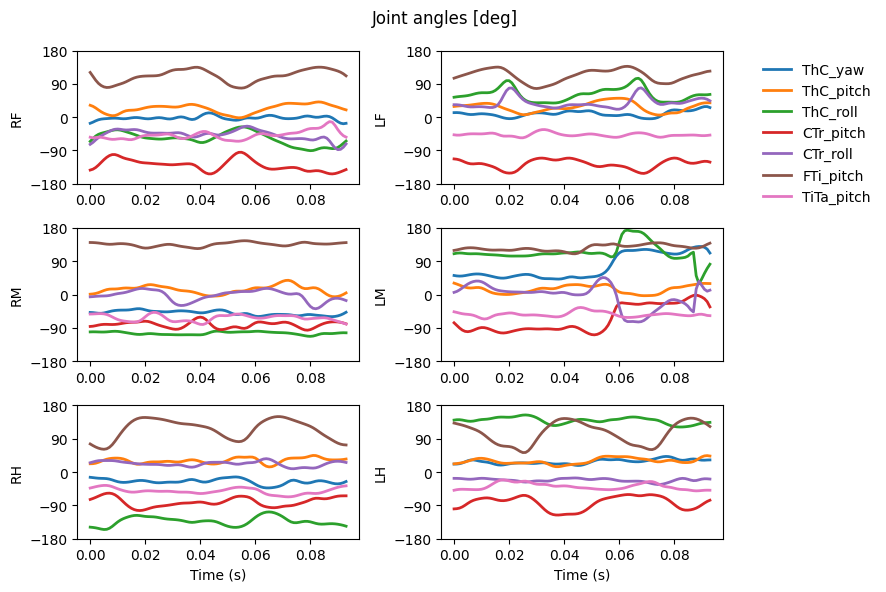

In [11]:
# Let's plot the joint angles for all six legs
plt.style.use('default')
fig, axs = plt.subplots(3,2, figsize=(9, 6), dpi=100)

time = np.arange(len(leg_joint_angles["Angle_LF_CTr_pitch"])) * aligned_pose_pp["meta"]["timestep"]

axs = axs.flatten()
for angle_name in ANGLES:
    for i, leg_name in enumerate(['RF', 'LF', 'RM', 'LM', 'RH', 'LH']):
        axs[i].plot(time,
            np.rad2deg(leg_joint_angles[f"Angle_{leg_name}_{angle_name}"]),
            label=angle_name,
            lw=2,
        )
        axs[i].set_ylabel(leg_name)
        axs[i].set_ylim(-180, 180)
        axs[i].set_yticks([-180, -90, 0, 90, 180])


axs[-1].set_xlabel("Time (s)")
axs[-2].set_xlabel("Time (s)")

axs[1].legend(bbox_to_anchor=(1.1, 1), frameon=False)

plt.suptitle('Joint angles [deg]')
plt.tight_layout()

# fig.savefig("../results/alljoints_follow_ikpy_left.png", bbox_inches="tight")
plt.show()

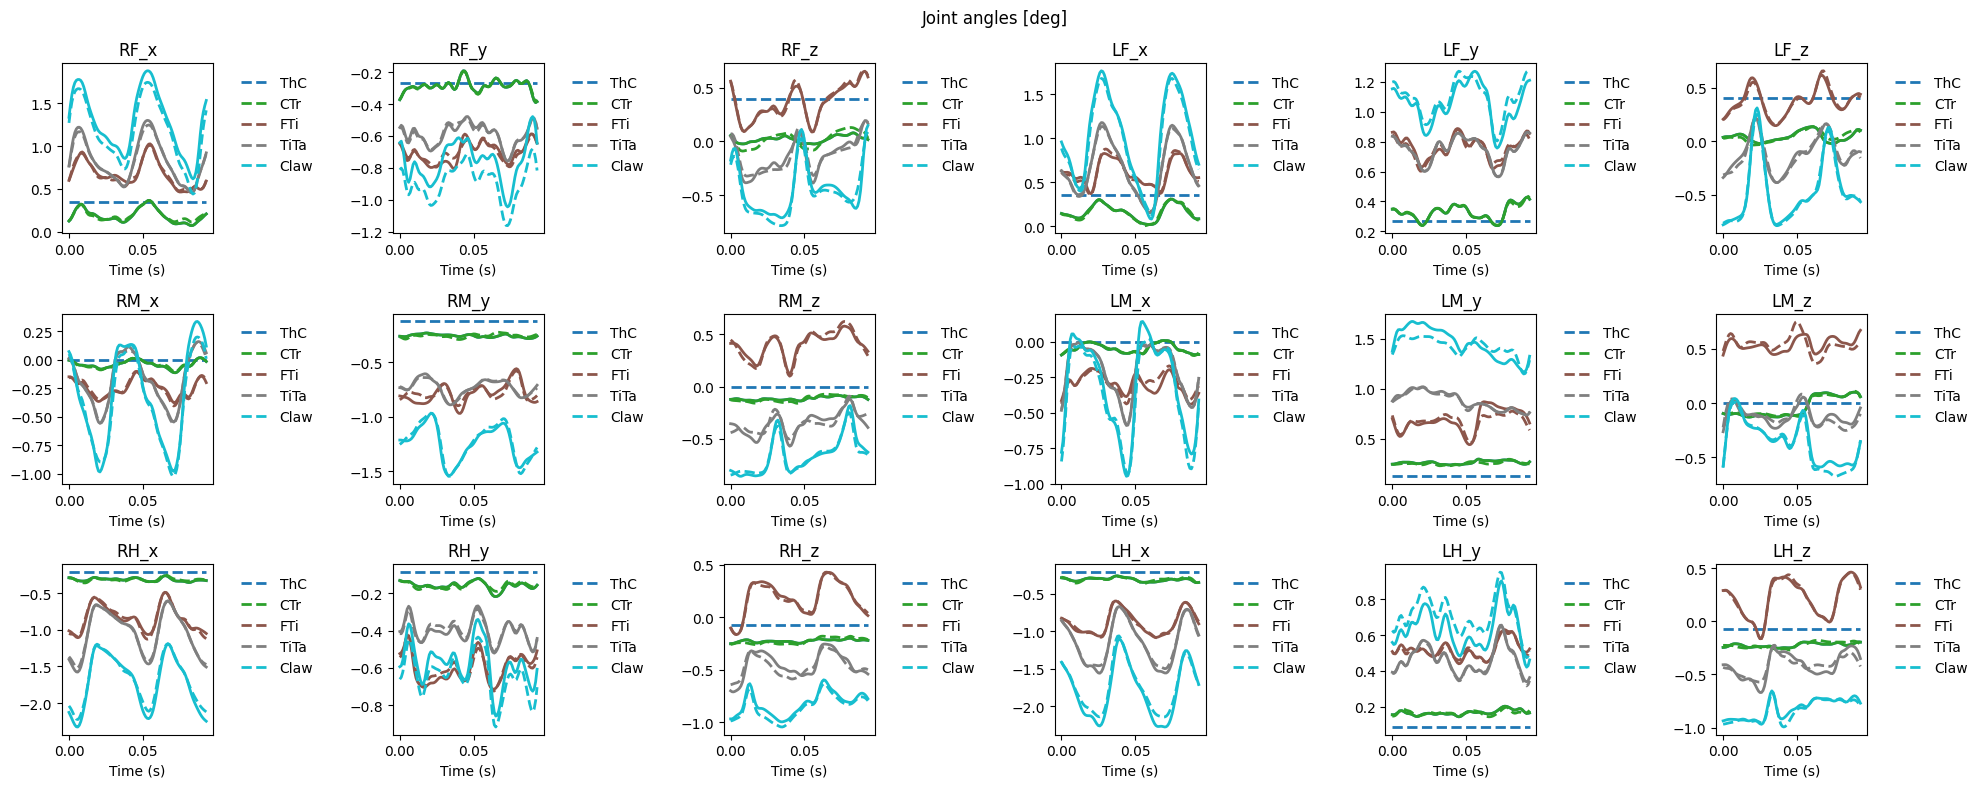

In [12]:
# plot forward kinematics and aligned pose
# Let's plot the joint angles for all six legs
plt.style.use('default')
fig, axs = plt.subplots(3,6, figsize=(20, 8), dpi=100)

time = np.arange(len(leg_joint_angles["Angle_LF_CTr_pitch"])) * aligned_pose_pp["meta"]["timestep"]
joints = ["ThC", "CTr", "FTi", "TiTa", "Claw"]

#get the colormap tab10
colors = plt.cm.tab10(np.linspace(0,1,len(joints)))

axs = axs.flatten()
for k, body_part in enumerate(joints):
    for i, leg_name in enumerate(['RF', 'LF', 'RM', 'LM', 'RH', 'LH']):
        for j in range(3):
            axs[i*3+j].plot(time,
                forward_kinematics[f"{leg_name}_leg"][:, -5:, :][:, k,j],
                lw=2,
                color=colors[k],
            )
            axs[i*3+j].plot(time,
                converted_aligned_pose[f"{leg_name}_leg"][:, k,j],
                label=body_part,
                linestyle='--',
                lw=2,
                color=colors[k],
            )
            axs[i*3+j].set_title(f"{leg_name}_{['x','y','z'][j]}")
            axs[i*3+j].set_xlabel("Time (s)")
            if k == len(joints)-1:
                axs[i*3+j].legend(bbox_to_anchor=(1.1, 1), frameon=False)

plt.suptitle('Joint angles [deg]')
plt.tight_layout()

# fig.savefig("../results/alljoints_follow_ikpy_left.png", bbox_inches="tight")
plt.show()

## 3D visualization

See scripts for more information.

In [13]:
# Files saved automatically after the IK-FK process above.
pose3d = aligned_pose_path
forward_kinematics_path = output_path / "forward_kinematics.pkl"

with open(pose3d, "rb") as f:
    aligned_pose = pickle.load(f)
with open(forward_kinematics_path, "rb") as f:
    forward_kin = pickle.load(f)

points_aligned_all = np.concatenate(
    (
        converted_aligned_pose["RF_leg"],
        converted_aligned_pose["RM_leg"],
        converted_aligned_pose["RH_leg"],
        converted_aligned_pose["LF_leg"],
        converted_aligned_pose["LM_leg"],
        converted_aligned_pose["LH_leg"],
    ),
    axis=1,
)

points_fk = np.concatenate(
    (
        forward_kin["RF_leg"],
        forward_kin["RM_leg"],
        forward_kin["RH_leg"],
        forward_kin["LF_leg"],
        forward_kin["LM_leg"],
        forward_kin["LH_leg"],
    ),
    axis=1,
)

export_path_ik_fk_comparison =  DATA_PATH / 'seqikpy_output/ik_fk_comparison'
export_path_ik_fk_comparison.mkdir(parents=True, exist_ok=True)


for t in range(0, points_aligned_all.shape[0], 1):
    for k, (azim, elev) in enumerate([(90,0),(90,-90), (30, 10)]):

        fig = plt.figure(figsize=(12, 12), layout="compressed")
        ax3d = fig.add_subplot(111, projection="3d")
        ax3d.view_init(azim=azim, elev=elev)

        ax3d.set_xlabel('x')
        ax3d.set_ylabel('y')
        ax3d.set_zlabel('z')
        
        plot_3d_points(
            ax3d,
            points_aligned_all,
            KEY_POINTS_DICT,
            label_prefix="Aligned pose ",
            t=t,
            fix_lim=False,
            export_path=None,
            lw=4.0
        )
        plot_3d_points(
            ax3d,
            points_fk,
            KEY_POINTS_DICT2,
            label_prefix="FK ",
            t=t,
            fix_lim= False,
            export_path=None,
            lw=4.0
        )
        ax3d.set_xlim([-2.5, 2.5])
        ax3d.set_ylim([-2.5, 2.5])
        ax3d.set_zlim([-2.5, 2.5])

        #ax3d.axis('off')
        ax3d.set_facecolor('black')  # Set black background
        
        # remove legend 
        if k != 1:
            ax3d.get_legend().remove()
        else:
            ax3d.get_legend().remove()
            # set a custom legend colors to the bottom right -, -- for aligned pose and FK both in white
            l1 = ax3d.plot([0], [0], color='white', linestyle='-')
            l2 = ax3d.plot([0], [0], color='white', linestyle='--')

            all_lines = ax3d.lines[:6] + l1 + l2
            all_names = list(KEY_POINTS_DICT.keys()) + ['Aligned pose', 'Forward Kinematics']
            legend = ax3d.legend(all_lines, all_names,
                                fontsize=15, frameon=False,
                                ncols=3, loc="center", bbox_to_anchor=(0.55, 0.24))
            ax3d.add_artist(legend)
            
        # set aspect ratio
        set_box_aspect(ax3d, aspect = 1)

        # tight layout
        #plt.tight_layout()
        # save without edges
        plt.savefig(export_path_ik_fk_comparison/ f'azim_{azim}_elev_{elev}_{t}.png', bbox_inches="tight", dpi=100, pad_inches=-1.5)
        plt.close()

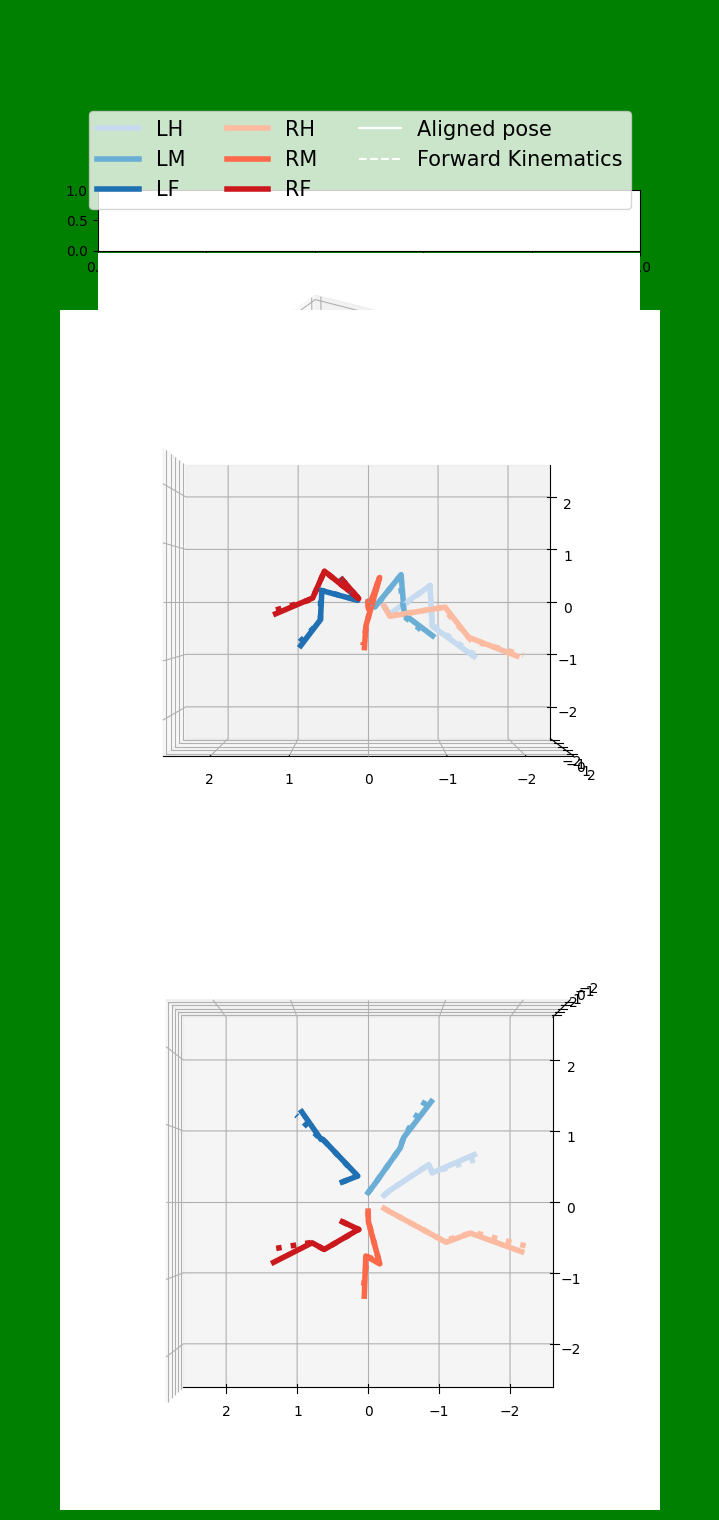

In [14]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

# Files saved automatically after the IK-FK process above.
pose3d = aligned_pose_path
forward_kinematics_path = output_path / "forward_kinematics.pkl"

with open(pose3d, "rb") as f:
    aligned_pose = pickle.load(f)
with open(forward_kinematics_path, "rb") as f:
    forward_kin = pickle.load(f)

points_aligned_all = np.concatenate(
    (
        converted_aligned_pose["RF_leg"],
        converted_aligned_pose["RM_leg"],
        converted_aligned_pose["RH_leg"],
        converted_aligned_pose["LF_leg"],
        converted_aligned_pose["LM_leg"],
        converted_aligned_pose["LH_leg"],
    ),
    axis=1,
)

points_fk = np.concatenate(
    (
        forward_kin["RF_leg"],
        forward_kin["RM_leg"],
        forward_kin["RH_leg"],
        forward_kin["LF_leg"],
        forward_kin["LM_leg"],
        forward_kin["LH_leg"],
    ),
    axis=1,
)

export_path_ikfk_mult =  DATA_PATH / 'seqikpy_output/fkik_mult'
export_path_ikfk_mult.mkdir(parents=True, exist_ok=True)



for t in range(0, points_aligned_all.shape[0], 1):
    fig = plt.figure(figsize=(7, 15))
    fig.set_facecolor("green")

    # Create a GridSpec layout
    gs = GridSpec(19, 1, figure=fig, wspace=0.0, hspace=0.0)

    # Add subplots
    legend_ax = fig.add_subplot(gs[0, 0])
    #legend_ax.set_facecolor('black')
    top_ax = fig.add_subplot(gs[1:10, 0], projection='3d')
    bottom_ax = fig.add_subplot(gs[10:19, 0], projection='3d')

    # Add subplots
    legend_ax = fig.add_subplot(gs[0, 0])
    legend_ax.set_facecolor('black')
    legend_ax.set_position([0.0, 0.8, 1.0, 0.2])  # Adjust position of the legend axes

    top_ax = fig.add_subplot(gs[1:10, 0], projection='3d')
    top_ax.set_position([0.0, 0.4, 1.0, 0.4])  # Adjust position of the top 3D axes

    bottom_ax = fig.add_subplot(gs[10:19, 0], projection='3d')
    bottom_ax.set_position([0.0, 0.0, 1.0, 0.4])  # Adjust posit

    axs = [top_ax, bottom_ax]
    for k, (azim, elev) in enumerate([(90,0),(90,-90)]):
        
        ax3d = axs[k]
        ax3d.view_init(azim=azim, elev=elev)
        
        plot_3d_points(
            ax3d,
            points_aligned_all,
            KEY_POINTS_DICT,
            label_prefix="Aligned pose ",
            t=t,
            fix_lim=False,
            export_path=None,
            lw=4.0
        )
        plot_3d_points(
            ax3d,
            points_fk,
            KEY_POINTS_DICT2,
            label_prefix="FK ",
            t=t,
            fix_lim= False,
            export_path=None,
            lw=4.0
        )
        ax3d.set_xlim([-2.5, 2.5])
        ax3d.set_ylim([-2.5, 2.5])
        ax3d.set_zlim([-2.5, 2.5])   
        #remove axis
        #ax3d.
        # remove legend 
        ax3d.get_legend().remove()
        
        if k == 0:
            # set a custom legend colors to the bottom right -, -- for aligned pose and FK both in white
            l1 = ax3d.plot([0], [0], color='white', linestyle='-')
            l2 = ax3d.plot([0], [0], color='white', linestyle='--')

            all_lines = ax3d.lines[:6] + l1 + l2
            all_names = list(KEY_POINTS_DICT.keys()) + ['Aligned pose', 'Forward Kinematics']
            # change the color of the box to black  
            legend_ax.legend(all_lines, all_names,
                                fontsize=15,
                                ncols=3, loc="center")
            # cet loc to central 
            legend_ax.set_axis_off()
            
        # tight layout
        #plt.tight_layout()
        # save without edges

    for ax in [legend_ax, top_ax, bottom_ax]:
        ax.set_facecolor("white")
    
    #plt.savefig(export_path_ikfk_mult/ f'pose3d_{t}.png', bbox_inches="tight", dpi=100, pad_inches=-1.5)
    plt.show()
    break
    plt.close()

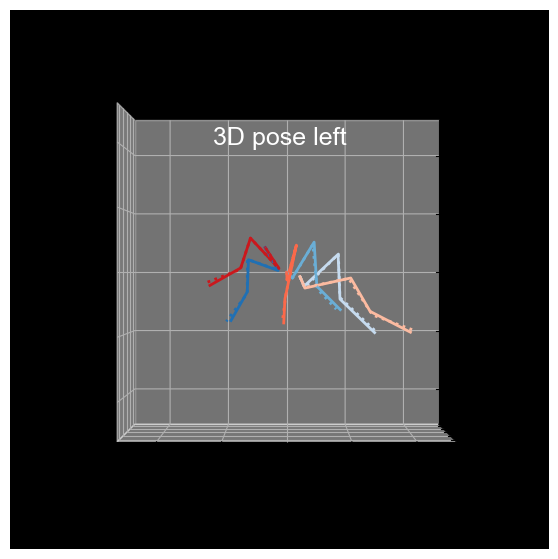

In [110]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

# Files saved automatically after the IK-FK process above.
pose3d = aligned_pose_path
forward_kinematics_path = output_path / "forward_kinematics.pkl"

with open(pose3d, "rb") as f:
    aligned_pose = pickle.load(f)
with open(forward_kinematics_path, "rb") as f:
    forward_kin = pickle.load(f)

points_aligned_all = np.concatenate(
    (
        converted_aligned_pose["RF_leg"],
        converted_aligned_pose["RM_leg"],
        converted_aligned_pose["RH_leg"],
        converted_aligned_pose["LF_leg"],
        converted_aligned_pose["LM_leg"],
        converted_aligned_pose["LH_leg"],
    ),
    axis=1,
)

points_fk = np.concatenate(
    (
        forward_kin["RF_leg"],
        forward_kin["RM_leg"],
        forward_kin["RH_leg"],
        forward_kin["LF_leg"],
        forward_kin["LM_leg"],
        forward_kin["LH_leg"],
    ),
    axis=1,
)

export_path_ikfk_mult =  DATA_PATH / 'seqikpy_output/fkik_mult'
export_path_ikfk_mult.mkdir(parents=True, exist_ok=True)

for t in range(0, points_aligned_all.shape[0], 1):
    for k, (azim, elev) in enumerate([(90,0),(90,-90)]):
        
        fig = plt.figure(figsize=(7, 7))
        ax3d = fig.add_subplot(111, projection='3d', azim=azim, elev=elev)
        
        plot_3d_points(
            ax3d,
            points_aligned_all,
            KEY_POINTS_DICT,
            label_prefix="Aligned pose ",
            t=t,
            fix_lim=False,
            export_path=None,
            lw=2.0
        )
        plot_3d_points(
            ax3d,
            points_fk,
            KEY_POINTS_DICT2,
            label_prefix="FK ",
            t=t,
            fix_lim= False,
            export_path=None,
            lw=2.0
        )
        ax3d.set_xlim([-2.5, 2.5])
        ax3d.set_ylim([-2.5, 2.5])
        ax3d.set_zlim([-2.5, 2.5])   
        #remove axis
        #ax3d.
        # remove legend 
        ax3d.get_legend().remove()

        if k == 0 and t == 0:
            fig_legend = plt.figure(figsize=(7, 2), facecolor='black')
            legend_ax = fig_legend.add_subplot(111, facecolor='black')
            # set a custom legend colors to the bottom right -, -- for aligned pose and FK both in white
            l1 = ax3d.plot([0], [0], color='white', linestyle='-')
            l2 = ax3d.plot([0], [0], color='white', linestyle='--')

            all_lines = ax3d.lines[:6] + l1 + l2
            all_names = list(KEY_POINTS_DICT.keys()) + ['Aligned pose', 'Forward Kinematics']
            # change the color of the box to black  
            legend_ax.legend(all_lines, all_names,
                                fontsize=12,
                                ncols=3, loc="center", frameon=False, labelcolor='white')
            # cet loc to central 
            legend_ax.set_axis_off()
            legend_ax.set_facecolor('black')
            # Get the figure size in inches
            fig_width, fig_height = fig_legend.get_size_inches()
            legend_bbox_crop = Bbox.from_bounds(fig_width*0.25, 0.0, fig_width*5.0, fig_height)

            # save legend_img to a file
            fig.savefig(export_path_ik_fk_comparison/"legend.png", dpi=200)
        
        ax3d.set_facecolor('black') 
        fig_width, fig_height = fig.get_size_inches()
        crop_bbox = Bbox.from_bounds(fig_width*0.25, fig_height*0.25, fig_width*0.5, fig_height*0.5)

        if k==0:
            #add tex
            ax3d.text2D(0.5, 0.75, f"3D pose left", transform=ax3d.transAxes, fontsize=18, color='white', ha='center')
        elif k==1:
            ax3d.text2D(0.5, 0.75, f"3D pose bottom", transform=ax3d.transAxes, fontsize=18, color='white', ha='center')

        ax3d.set_box_aspect([1, 1, 1])

        fig.savefig(export_path_ik_fk_comparison/ f'azim_{azim}_elev_{elev}_{t}.png', bbox_inches=crop_bbox, dpi=200)       

        plt.close()